<a href="https://colab.research.google.com/github/krldlamini/edm_brazildengue/blob/main/CCM_Analysis/notebooks/ExtendedCCM_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyEDM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 19.3 MB/s eta 0:00:00


In [2]:
from pyEDM import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style='white')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Combined_Files/SP_RDJ_MinMax/355030_A701_combined.csv'
#file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Combined_Files/SP_RDJ_MinMax/330455_A652_combined.csv'
data_sp = pd.read_csv(file_path, delimiter = ',')

# Drop NAs

In [5]:
data_sp = data_sp.dropna()

In [6]:
data_sp_backup = data_sp.copy()
data_sp_backup['month'] = pd.DatetimeIndex(data_sp_backup['data']).month
data_sp = data_sp.drop(columns = ['data'])

In [7]:
data_sp

,Unnamed: 0,cases,precipitacao_total_horario,temperatura_maxima_na_hora_ant,temperatura_minima_na_hora_ant,umidade_rel_max_na_hora_ant,umidade_rel_min_na_hora_ant
0,0,0,10.2,31.2,18.3,94.0,27.0
1,1,23,50.0,30.0,17.6,95.0,38.0
2,2,28,27.8,30.2,17.8,95.0,39.0
3,3,15,26.6,32.4,17.9,94.0,35.0
4,4,24,149.8,31.8,18.8,96.0,38.0
...,...,...,...,...,...,...,...
776,776,15,8.4,32.2,16.9,89.0,28.0
777,777,25,9.0,33.7,14.0,90.0,14.0
778,778,37,117.4,30.0,17.1,96.0,43.0
779,779,31,15.8,32.2,15.3,92.0,20.0


# Find the right embedding dimension

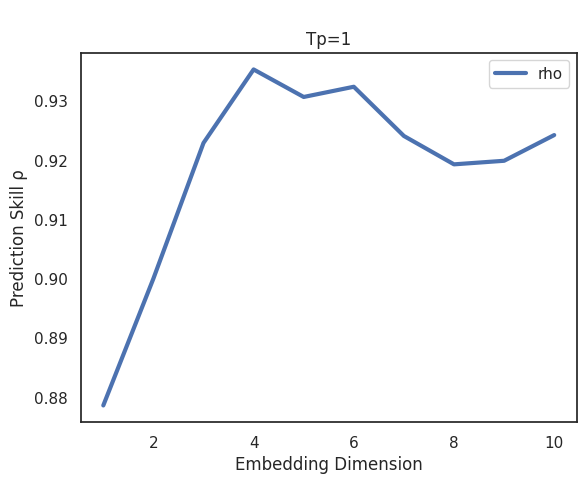

In [8]:
rho_E = EmbedDimension(dataFrame = data_sp, columns = 'cases',
                        target = 'cases', lib = '1 780',
                        pred = '1 780', showPlot = True)

In [9]:
rho_E

,E,rho
0,1.0,0.878601
1,2.0,0.900019
2,3.0,0.922919
3,4.0,0.935328
4,5.0,0.930683
5,6.0,0.932407
6,7.0,0.924097
7,8.0,0.919306
8,9.0,0.919910
9,10.0,0.924251


# Doing Extended or Lagged CCM

# Normalizing the data

In [10]:
data_sp_norm = (data_sp-data_sp.mean())/data_sp.std()

# Calculating interaction strengths (as in the malaria paper)

# Calculating optimal  θ

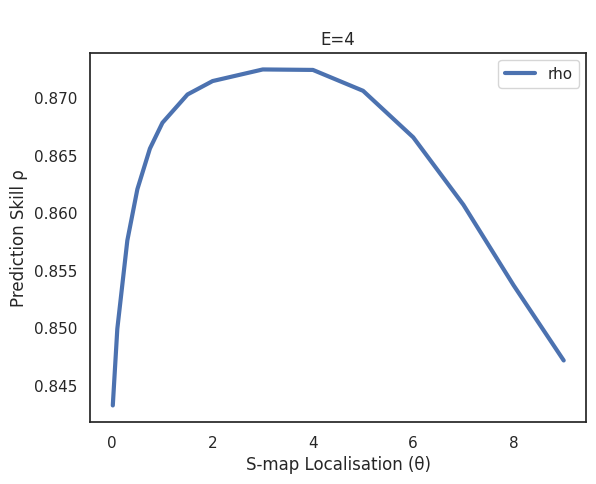

In [11]:
rho_theta = PredictNonlinear(dataFrame = data_sp_norm, lib = "1 780", pred = "1 780",
target = 'cases', columns = 'cases', E = 4)

In [12]:
rho_theta[rho_theta['rho'] == max(rho_theta['rho'])]

,Theta,rho
8,3.0,0.872477


# Doing Smap Coefficients

In [21]:
#precip = np.array(data_sp_norm['precipitacao_total_horario'])
cases = np.array(data_sp_norm['cases'])[7:]
temp_max = np.array(data_sp_norm['temperatura_maxima_na_hora_ant'])[4:-3]
temp_min =  np.array(data_sp_norm['temperatura_minima_na_hora_ant'])[4:-3]

In [23]:
len(temp_max)

773

In [24]:
data_sp_smap = pd.DataFrame({'cases':cases, 'temp_max': temp_max, 'temp_min': temp_min})
data_sp_smap = data_sp_smap.reset_index()
smap = SMap(dataFrame = data_sp_smap, lib = "1 773", pred = "1 773", E = 4,
theta = 3, columns = "temp_min temp_max", target = "cases", Tp = 0, embedded = True)

In [16]:
smap

{'predictions':     index  Observations  Predictions  Pred_Variance
 0       0     -0.246756     0.173635       2.256783
 1       1     -0.198253    -0.122997       1.505300
 2       2     -0.146516     0.127812       1.938631
 3       3     -0.117413     0.196721       2.210966
 4       4     -0.026874     0.015981       1.726473
 ..    ...           ...          ...            ...
 767   767     -0.262924     0.164046       1.584219
 768   768     -0.266157    -0.169337       0.493629
 769   769     -0.249989    -0.271506       0.810867
 770   770     -0.230588    -0.268661       0.977457
 771   771     -0.240289     0.241601       2.294281
 
 [772 rows x 4 columns],
 'coefficients':     index        C0  ∂cases/∂temp_min  ∂cases/∂temp_max
 0       0  0.841173         -0.416974         -0.202606
 1       1  0.199514          0.513548         -0.542772
 2       2  0.644682         -0.093905         -0.419662
 3       3  0.777155         -0.247974         -0.346004
 4       4  0.579504 

# Plotting the interaction strengths (without colouring by months)

In [25]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']

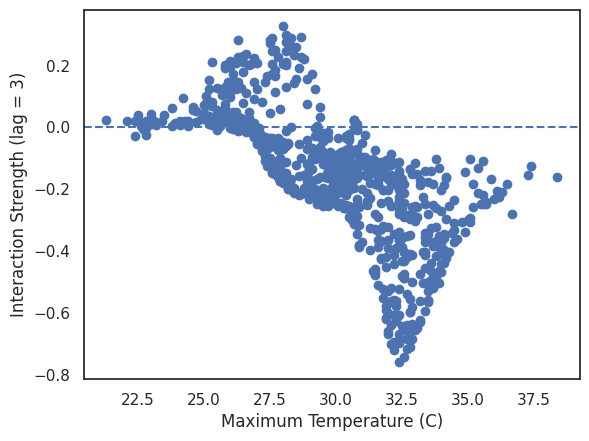

In [27]:
plt.plot(np.array(data_sp_backup['temperatura_maxima_na_hora_ant'])[4:-3], coefs_maxtemp, 'o')
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.show()

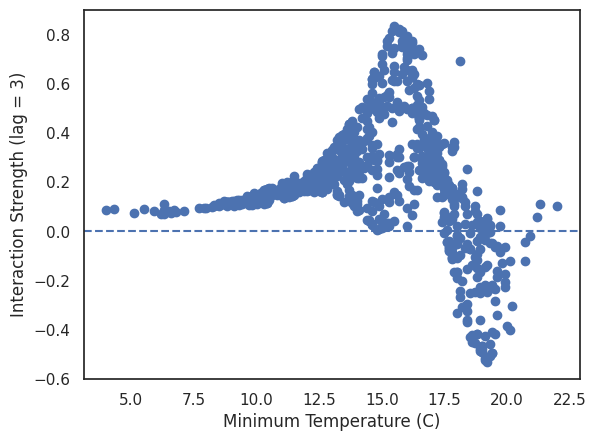

In [29]:
plt.plot((data_sp['temperatura_minima_na_hora_ant'])[4:-3],coefs_mintemp, 'o')
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.show()

# Plotting the interaction strengths (colouring by months)

In [30]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']
#coefs_precip = smap['coefficients']['∂cases/∂precip']

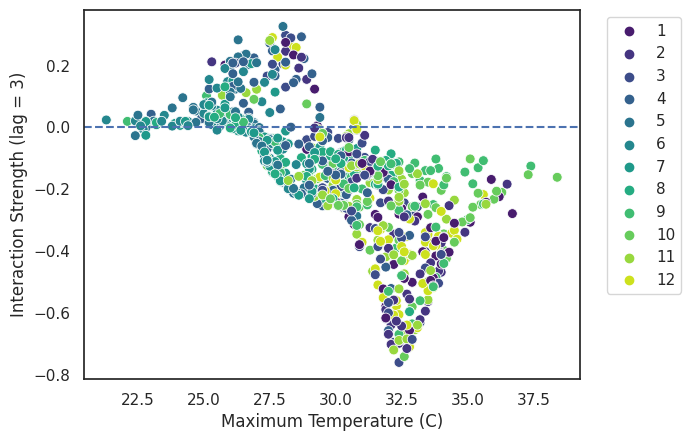

In [32]:
sns.scatterplot(x = np.array(data_sp['temperatura_maxima_na_hora_ant'])[4:-3], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[4:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

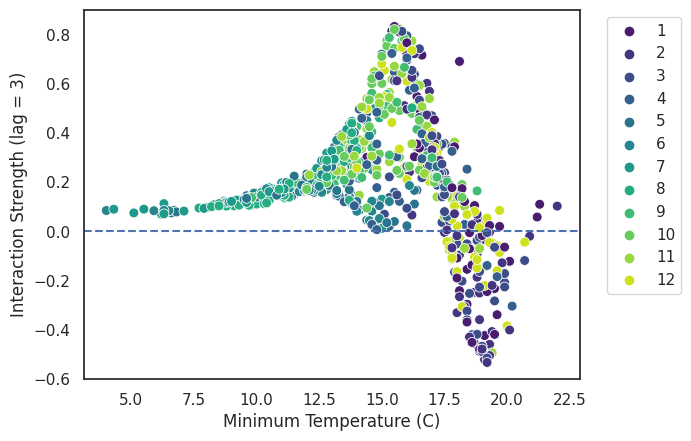

In [ ]:
sns.scatterplot(x = np.array(data_sp['temperatura_minima_na_hora_ant'])[4:-3], y =coefs_mintemp,  hue = np.array(data_sp_backup['month'])[4:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

# Incorporating precipitation

In [40]:
precip = np.array(data_sp_norm['precipitacao_total_horario'])[6:-2]
cases = np.array(data_sp_norm['cases'])[8:]
temp_max = np.array(data_sp_norm['temperatura_maxima_na_hora_ant'])[5:-3]
temp_min =  np.array(data_sp_norm['temperatura_minima_na_hora_ant'])[5:-3]

In [44]:
len(temp_min)

772

In [45]:
data_sp_smap = pd.DataFrame({'cases':cases, 'precip': precip,'temp_max': temp_max, 'temp_min': temp_min})
data_sp_smap = data_sp_smap.reset_index()
smap = SMap(dataFrame = data_sp_smap, lib = "1 772", pred = "1 772", E = 4,
theta = 3, columns = "temp_max temp_min precip", target = "cases", Tp = 0, embedded = True)

In [46]:
smap

{'predictions':     index  Observations  Predictions  Pred_Variance
 0       0     -0.198253    -0.098001       1.474448
 1       1     -0.146516     0.067102       1.124264
 2       2     -0.117413     0.101856       1.255364
 3       3     -0.026874     0.669122       2.892511
 4       4      0.110553     0.186814       1.424632
 ..    ...           ...          ...            ...
 767   767     -0.266157    -0.160977       0.740877
 768   768     -0.249989    -0.238730       0.676202
 769   769     -0.230588    -0.254712       0.737589
 770   770     -0.240289     0.150653       1.202202
 771   771     -0.272624    -0.274646       1.981620
 
 [772 rows x 4 columns],
 'coefficients':     index        C0  ∂cases/∂temp_max  ∂cases/∂temp_min  ∂cases/∂precip
 0       0 -0.082775         -0.247964          0.339494        0.066884
 1       1  0.373207         -0.337109          0.008246       -0.002988
 2       2  0.497314         -0.357484         -0.091991        0.008754
 3       3 -0.

In [47]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']
coefs_precip = smap['coefficients']['∂cases/∂precip']

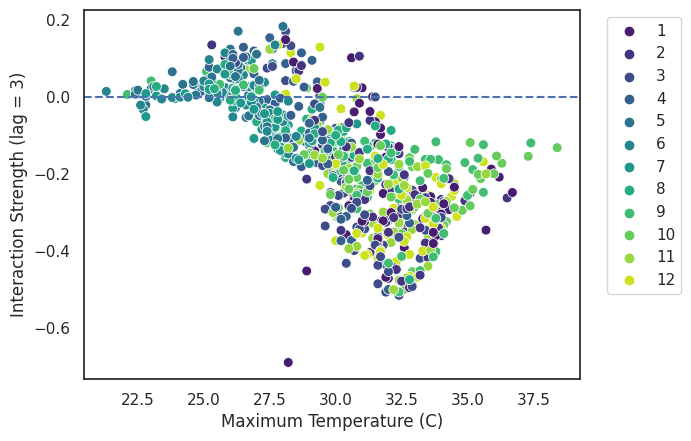

In [49]:
sns.scatterplot(x = np.array(data_sp['temperatura_maxima_na_hora_ant'])[5:-3], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[5:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

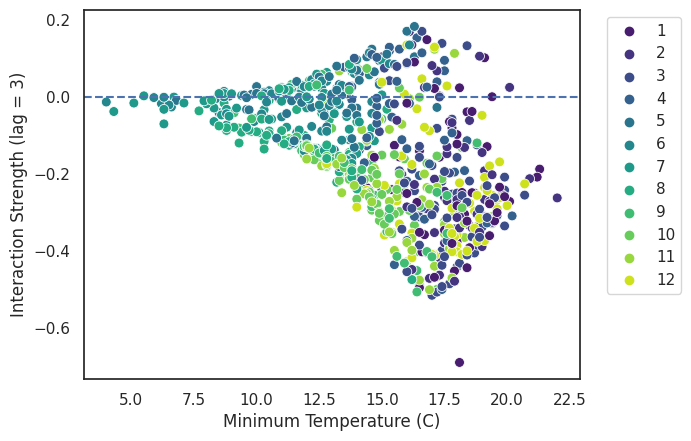

In [51]:
sns.scatterplot(x = np.array(data_sp['temperatura_minima_na_hora_ant'])[5:-3], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[5:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

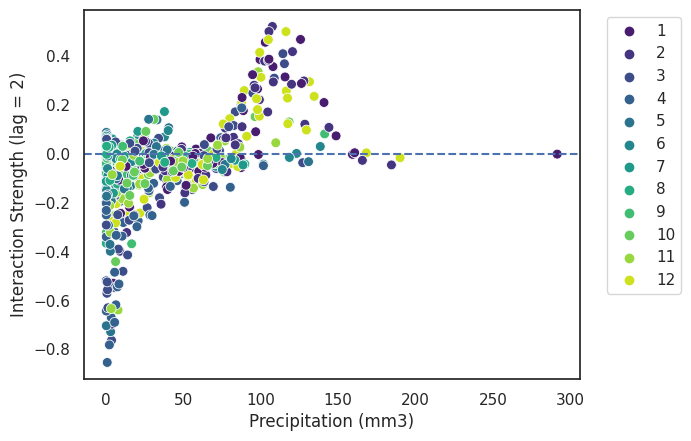

In [53]:
sns.scatterplot(x = np.array(data_sp['precipitacao_total_horario'])[6:-2], y =coefs_precip,  hue = np.array(data_sp_backup['month'])[6:-2], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Precipitation (mm3)')
plt.ylabel('Interaction Strength (lag = 2)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()